# Imports and paths

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cycler
import glob
from IPython.display import display
import os
import sys
from datetime import date,timedelta
import json
import numpy as np
import time
from math import cos, sin
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
import math 
from scipy import signal
from scipy import stats
from scipy.stats import ttest_ind
import scipy.stats
from statsmodels.robust import scale
import statsmodels.api as sm
pd.options.mode.chained_assignment = None  # default='warn'
from statsmodels.formula.api import ols
from patsy.contrasts import Treatment
from patsy.contrasts import ContrastMatrix
from patsy.contrasts import Sum
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,MultiComparison)

In [2]:
#Mac
All_data = pd.read_csv(r'/Users/shadiderakhshan/Desktop/VirtualTime/SAVE/PCA_analysis.csv')

#windows
#All_data = pd.read_csv(r'C:\Users\sderakhshan\Desktop\VirtualTime\SAVE\All_data_gaze_columns_final.csv')

In [3]:
#All_data=All_data.drop(['eye_theta_v','eye_theta_v_int'],axis=1)

In [4]:
All_data.columns

Index(['uid', 'Condition', 'TobiiTimeStamp', 'UnixTimeStamp', 'Man_Timestamp',
       'HmdPosition_x', 'HmdPosition_y', 'HmdPosition_z', 'NoseVector_x',
       'NoseVector_y', 'NoseVector_z', 'HmdRotation_x', 'HmdRotation_y',
       'HmdRotation_z', 'HmdRotation_w', 'EyePositionCombinedWorld_x',
       'EyePositionCombinedWorld_y', 'EyePositionCombinedWorld_z',
       'EyeDirectionCombinedWorld_x', 'EyeDirectionCombinedWorld_y',
       'EyeDirectionCombinedWorld_z', 'EyePositionCombinedLocal_x',
       'EyePositionCombinedLocal_y', 'EyePositionCombinedLocal_z',
       'EyeDirectionCombinedLocal_x', 'EyeDirectionCombinedLocal_y',
       'EyeDirectionCombinedLocal_z', 'CarPosition_x', 'CarPosition_y',
       'CarPosition_z', 'CarRotation_x', 'CarRotation_y', 'CarRotation_z',
       'CarRotation_w', 'TimeStampNr', 'Auto_TimeStamp', 'Auto_TobiiTimeStamp',
       'SteeringInput', 'AcellerationInput', 'BrakeInput'],
      dtype='object')

In [6]:
#Mac
#Object = pd.read_csv(r'/Users/shadiderakhshan/Desktop/VirtualTime/SAVE/HitObject.csv')

#windows
#All_data = pd.read_csv(r'C:\Users\sderakhshan\Desktop\VirtualTime\SAVE\All_data_gaze_columns_final.csv')

In [7]:
#Object

## adding gaze

In [8]:
def RotationStuff(df_A):   

    df_B = pd.DataFrame()
    # We want the head rotation horizontal
    # we have the eyedirection_world, car rotation and eye direction local
    # headrotation should be the eyedirection world minus car rotation and minus eye local
    # car rotation is in quaternion
    # eyedirection world is euler so is eyelocal

    #Car rotation to Rotation Matrix
    df_B['CarRotation_all'] = df_A[[
    'CarRotation_x', 'CarRotation_y', 'CarRotation_z', 'CarRotation_w'
    ]].apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_B['AutoRotation_R'] = df_B['CarRotation_all'].apply(R)
    df_B['AutoRotation_R_euler'] = df_B['AutoRotation_R'].apply(Euler)
    #df_B['AutoRotation_R_euler_Z'] = df_B['AutoRotation_R_euler'].apply(lambda x: x[0])
    #df_B['AutoRotation_R_euler_Y'] = df_B['AutoRotation_R_euler'].apply(lambda x: x[1])
    #df_B['AutoRotation_R_euler_X'] = df_B['AutoRotation_R_euler'].apply(lambda x: x[2])

    df_B['EyeDirectionCombinedWorld'] = df_A[['EyeDirectionCombinedWorld_z', 'EyeDirectionCombinedWorld_y',
       'EyeDirectionCombinedWorld_x'
    ]].apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_B['Combined_Nose'] = df_A[['NoseVector_z', 'NoseVector_y',
       'NoseVector_x'
    ]].apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_B['AutoRotation_R_inv'] = (df_B['AutoRotation_R'].apply(lambda x: x.inv()))
    df_B['New_Nose'] = df_B['AutoRotation_R_inv']
    df_B['New_Direction_2'] = df_B['AutoRotation_R']
    for index, row in df_B.iterrows():
        #row['New_Direction']= (row['AutoRotation_R_inv'].apply(row['EyeDirectionCombinedWorld']))
        row['New_Direction_2']= (row['AutoRotation_R'].apply(row['EyeDirectionCombinedWorld']))
        row['New_Nose']=(row['AutoRotation_R'].apply(row['Combined_Nose']))

    df_B['HeadRotation_R_euler_Z'] = df_B['New_Direction_2'].apply(lambda x: x[0])
    df_B['HeadRotation_R_euler_Y'] = df_B['New_Direction_2'].apply(lambda x: x[1])
    df_B['HeadRotation_R_euler_X'] = df_B['New_Direction_2'].apply(lambda x: x[2])
    df_B['Nose_euler_Z'] = df_B['New_Nose'].apply(lambda x: x[0])
    df_B['Nose_euler_Y'] = df_B['New_Nose'].apply(lambda x: x[1])
    df_B['Nose_euler_X'] = df_B['New_Nose'].apply(lambda x: x[2])

    df_B.reset_index(inplace=False)
    df_A['eye_theta_h_HEAD'] = np.arctan2(df_B['HeadRotation_R_euler_X'], 
                                           df_B['HeadRotation_R_euler_Z'])
    df_A['eye_theta_h_World'] = np.arctan2(df_A['EyeDirectionCombinedWorld_x'], 
                                           df_A['EyeDirectionCombinedWorld_z'])
    
    df_A['nose_theta_h'] = np.arctan2(df_B['Nose_euler_X'], 
                                           df_B['Nose_euler_Z'])
    df_A['AutoRotation_R_Y'] = df_B['AutoRotation_R_euler'].apply(lambda x: x[1])
    df_A['Head_theta_h'] = df_A['eye_theta_h_HEAD'] - df_A['eye_theta_h'] 
    df_A = ThetaWorldToNan(df_A,'Head_theta_h') 
    df_A = ThetaWorldToNan(df_A,'eye_theta_h_HEAD') 
    df_A = ThetaWorldToNan(df_A,'eye_theta_h') 
    df_A = ThetaWorldToNan(df_A,'eye_theta_h_World')
    
    """
    #Eyedirection_world to TM

    df_B['EyeDirectionCombinedWorld_R'] = df_B['EyeDirectionCombinedWorld'].apply(From_Euler)

    #Eyedirection_Local to TM

    df_B['EyeDirectionCombinedLocal'] = df_A[['EyeDirectionCombinedLocal_z', 'EyeDirectionCombinedLocal_y',
       'EyeDirectionCombinedLocal_x'
    ]].apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_B['EyeDirectionCombinedLocal_R'] = df_B['EyeDirectionCombinedLocal'].apply(From_Euler)

    df_B['PureHead'] = df_B['EyeDirectionCombinedWorld_R']*(df_B['AutoRotation_R'].apply(lambda x: x.inv()))*(df_B['EyeDirectionCombinedLocal_R'].apply(lambda x: x.inv()))


    #Car rotation to Euler
    df_B['HeadRotation_R_euler'] = df_B['PureHead'].apply(Euler)

    ### spliting zyx values
    df_B['HeadRotation_R_euler_Z'] = df_B['HeadRotation_R_euler'].apply(lambda x: x[0])
    df_B['HeadRotation_R_euler_Y'] = df_B['HeadRotation_R_euler'].apply(lambda x: x[1])
    df_B['HeadRotation_R_euler_X'] = df_B['HeadRotation_R_euler'].apply(lambda x: x[2])

    df_B.reset_index(inplace=False)
    df_A['eye_theta_h_HEAD'] = np.arctan2(df_B['HeadRotation_R_euler_X'], 
                                           df_B['HeadRotation_R_euler_Z'])

    df_A['eye_theta_h_Car'] = np.arctan2(df_B['AutoRotation_R_euler_X'], 
                                           df_B['AutoRotation_R_euler_Z'])
    df_B['time_from_start'] = df_A['time_from_start']"""
    #print(df_A.columns)
    #display(df_A)
    return df_A

In [9]:
#ssssss

### practice 

# Preparing df

## functions

1. This function is taking a DataFrame, with a Unix timestamp column, converting it to datetime objects, using it as the index, creating a new column with time duration and returning the modified DataFrame.

In [10]:
def time_convert(df):
    df['timestamp_REF'] = pd.to_datetime(df.Auto_TobiiTimeStamp,
                                         utc=True,
                                         unit='s',
                                         origin='unix')

    df.set_index('timestamp_REF', inplace=True)
    df['Time_duration'] = (df.groupby(
        ['uid'], as_index=False).transform(lambda x: (x.index - x.index[
            0]) / np.timedelta64(1, 's')).TobiiTimeStamp)
    df.reset_index(drop=False)
    return df

In [11]:
def time_convert_2(df):
    df['timestamp_REF'] = pd.to_datetime(df.Auto_TobiiTimeStamp,
                                         utc=True,
                                         unit='s',
                                         origin='unix')

    df.set_index('timestamp_REF', inplace=True)
    df['Time_duration'] = (df.groupby(
        ['uid']).transform(lambda x: (x.index - x.index[
            0]) / np.timedelta64(1, 's')).TobiiTimeStamp)
    df = df.reset_index(drop=False)

    # Add a new column 'Row_Number' which stores the row number for each participant.
    df['Frame'] = df.groupby('uid').cumcount() + 1

    return df

2. This function calculates the dilation of the pupil size of the left and right eye by calculating the mean and then converts the radian to degree.

In [12]:
def eye_orientation(df):
    df = df.assign(
        Pupil_Dilation=(df['pupilDiameterMillimetersLeft'] +
                        df['pupilDiameterMillimetersRight']) / 2,
        eye_theta_h_int_degree=df['eye_theta_h_int'].astype(float).apply(
            math.degrees),
        eye_theta_h_HEAD_degree=df['eye_theta_h_HEAD'].astype(float).apply(
            math.degrees),
        nose_theta_h_degree=df['nose_theta_h'].astype(float).apply(
            math.degrees),
        Head_theta_h_degree=df['Head_theta_h'].astype(float).apply(
            math.degrees),
        AutoRotation_R_Y_degree=df['AutoRotation_R_Y'].astype(float).apply(
            math.degrees))

    return df

3. This function selects the column of interest in the df

In [13]:
def select_columns(df):
    cols = [
        'Time_duration', 'uid', 'eye_theta_h_int_degree', 'Pupil_Dilation',
       # 'ObjectName_0', 'ObjectName_1', 'ObjectName_2', 'ObjectName_3',
        'Event', 'Condition', 'eye_theta_h_HEAD_degree', 'nose_theta_h_degree',
        'Head_theta_h_degree', 'AutoRotation_R_Y_degree'
    ]
    return df[cols].reset_index()

#'SteeringInput','AcellerationInput', 'BrakeInput'

4. This function removes the columns with 0 values. We did this because we wanted to remove the participants with incomplete ride.

In [14]:
def remove_zero_eye_theta(df):
    return df[df.eye_theta_h_int_degree != 0]

def remove_zero_Pupil_Dilation(df):
    return df[df.Pupil_Dilation != 0]

def remove_zero_Steering_Input(df):
    return df[df.SteeringInput != 0]

In [15]:
#count = (All_Manual['eye_theta_h_int_degree'] == 0).sum()

5. This function determines the length of the events

In [16]:
def define_event_column(df):
    df['Event'] = 'NoEv'
    
    df.loc[(df['Time_duration'] > 20.81543) &
           (df['Time_duration'] < 30.975586), 'Event'] = 'one'
    df.loc[(df['Time_duration'] > 63.350586) &
           (df['Time_duration'] < 81.875), 'Event'] = 'two'
    df.loc[(df['Time_duration'] > 134.415039) &
           (df['Time_duration'] < 157.28418), 'Event'] = 'three'

    df.loc[(df['Time_duration'] > 188.579102) &
           (df['Time_duration'] < 198.750977), 'Event'] = 'four'
    df.loc[(df['Time_duration'] > 228.447266) &
           (df['Time_duration'] < 243.241211), 'Event'] = 'five'
    df.loc[(df['Time_duration'] > 267.006836) &
           (df['Time_duration'] < 280.178711), 'Event'] = 'six'

    df.loc[(df['Time_duration'] > 325.889648) &
           (df['Time_duration'] < 345.359375), 'Event'] = 'seven'
    df.loc[(df['Time_duration'] > 382.21875) &
           (df['Time_duration'] < 401.822266), 'Event'] = 'eight'
    df.loc[(df['Time_duration'] > 432.363281) &
           (df['Time_duration'] < 447.792969), 'Event'] = 'nine'
    df.loc[(df['Time_duration'] > 464.603516) &
           (df['Time_duration'] < 471.923828), 'Event'] = 'ten'
    
    
    df.loc[(df['Time_duration'] > 20.81543 - 10) &
           (df['Time_duration'] < 20.81543), 'Event'] = 'one_BE'
    df.loc[(df['Time_duration'] > 30.975586) &
           (df['Time_duration'] < 30.975586 + 10), 'Event'] = 'one_AF'

    df.loc[(df['Time_duration'] > 63.350586 - 10) &
           (df['Time_duration'] < 63.350586), 'Event'] = 'two_BE'
    df.loc[(df['Time_duration'] > 81.875) &
           (df['Time_duration'] < 81.875 + 10), 'Event'] = 'two_AF'

    df.loc[(df['Time_duration'] > 134.415039 - 10) &
           (df['Time_duration'] < 134.415039), 'Event'] = 'three_BE'
    df.loc[(df['Time_duration'] > 157.28418) &
           (df['Time_duration'] < 157.28418 + 10), 'Event'] = 'three_AF'

    df.loc[(df['Time_duration'] > 188.579102 - 10) &
           (df['Time_duration'] < 188.579102), 'Event'] = 'four_BE'
    df.loc[(df['Time_duration'] > 198.750977) &
           (df['Time_duration'] < 198.750977 + 10), 'Event'] = 'four_AF'

    df.loc[(df['Time_duration'] > 228.447266 - 10) &
           (df['Time_duration'] < 228.447266), 'Event'] = 'five_BE'
    df.loc[(df['Time_duration'] > 243.241211) &
           (df['Time_duration'] < 243.241211 + 10), 'Event'] = 'five_AF'

    df.loc[(df['Time_duration'] > 267.006836 - 10) &
           (df['Time_duration'] < 267.006836), 'Event'] = 'six_BE'
    df.loc[(df['Time_duration'] > 280.178711) &
           (df['Time_duration'] < 280.178711 + 10), 'Event'] = 'six_AF'

    df.loc[(df['Time_duration'] > 325.889648 - 10) &
           (df['Time_duration'] < 325.889648), 'Event'] = 'seven_BE'
    df.loc[(df['Time_duration'] > 345.359375) &
           (df['Time_duration'] < 345.359375 + 10), 'Event'] = 'seven_AF'

    df.loc[(df['Time_duration'] > 382.21875 - 10) &
           (df['Time_duration'] < 382.21875), 'Event'] = 'eight_BE'
    df.loc[(df['Time_duration'] > 401.822266) &
           (df['Time_duration'] < 401.822266 + 10), 'Event'] = 'eight_AF'

    df.loc[(df['Time_duration'] > 432.363281 - 10) &
           (df['Time_duration'] < 432.363281), 'Event'] = 'nine_BE'
    df.loc[(df['Time_duration'] > 447.792969) &
           (df['Time_duration'] < 447.792969 + 10), 'Event'] = 'nine_AF'

    df.loc[(df['Time_duration'] > 464.603516 - 10) &
           (df['Time_duration'] < 464.603516), 'Event'] = 'ten_BE'
    df.loc[(df['Time_duration'] > 471.923828) &
           (df['Time_duration'] < 471.923828 + 10), 'Event'] = 'ten_AF'

    return df

## apply

In [17]:
All_data = All_data.pipe(time_convert_2).pipe(define_event_column)  #.pipe(select_columns)
#All_data = All_data.pipe(time_convert).pipe(eye_orientation).pipe(define_event_column)

In [18]:
All_data

,timestamp_REF,uid,Condition,TobiiTimeStamp,UnixTimeStamp,Man_Timestamp,HmdPosition_x,HmdPosition_y,HmdPosition_z,NoseVector_x,...,CarRotation_w,TimeStampNr,Auto_TimeStamp,Auto_TobiiTimeStamp,SteeringInput,AcellerationInput,BrakeInput,Time_duration,Frame,Event
0,1970-01-01 02:56:39.665039062+00:00,61dafd5932a04da8a02ef42aa7689d8e,Manual,7073.046387,1.622896e+09,2021-06-05 12:26:30.656433920+00:00,154.063354,377.118896,432.080322,0.952234,...,0.787967,0,2021-08-28 12:58:35.301991680+00:00,10599.665039,-0.029593,0.0,0.0,0.000000,1,NoEv
1,1970-01-01 02:56:39.686523437+00:00,61dafd5932a04da8a02ef42aa7689d8e,Manual,7073.046387,1.622896e+09,2021-06-05 12:26:30.656433920+00:00,154.063354,377.118896,432.080322,0.952234,...,0.787967,1,2021-08-28 12:58:35.311311872+00:00,10599.686523,-0.029593,0.0,0.0,0.021484,2,NoEv
2,1970-01-01 02:56:39.699218750+00:00,61dafd5932a04da8a02ef42aa7689d8e,Manual,7073.046387,1.622896e+09,2021-06-05 12:26:30.656433920+00:00,154.063354,377.118896,432.080322,0.952234,...,0.787967,2,2021-08-28 12:58:35.324454912+00:00,10599.699219,-0.029593,0.0,0.0,0.034180,3,NoEv
3,1970-01-01 02:56:39.721679687+00:00,61dafd5932a04da8a02ef42aa7689d8e,Manual,7073.046387,1.622896e+09,2021-06-05 12:26:30.656433920+00:00,154.063354,377.118896,432.080322,0.952234,...,0.787967,3,2021-08-28 12:58:35.348636672+00:00,10599.721680,-0.029593,0.0,0.0,0.056641,4,NoEv
4,1970-01-01 02:56:39.743164062+00:00,61dafd5932a04da8a02ef42aa7689d8e,Manual,7073.046387,1.622896e+09,2021-06-05 12:26:30.656433920+00:00,154.063354,377.118896,432.080322,0.952234,...,0.787967,4,2021-08-28 12:58:35.369984256+00:00,10599.743164,-0.029593,0.0,0.0,0.078125,5,NoEv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17018277,1970-01-01 03:04:33.920898437+00:00,4ae61cb106644015999b7643d088865c,TaxiDriver,10456.440430,1.627988e+09,2021-08-03 10:56:38.585592832+00:00,-1497.368652,131.267822,2378.349365,-0.148437,...,0.941597,9052,2021-08-28 13:06:29.546332928+00:00,11073.920898,-0.006865,0.0,0.0,474.255859,24573,ten_AF
17018278,1970-01-01 03:04:33.943359375+00:00,4ae61cb106644015999b7643d088865c,TaxiDriver,10456.474609,1.627988e+09,2021-08-03 10:56:38.618507520+00:00,-1496.769653,131.211639,2379.055908,-0.154362,...,0.942265,9053,2021-08-28 13:06:29.569185024+00:00,11073.943359,-0.006865,0.0,0.0,474.278320,24574,ten_AF
17018279,1970-01-01 03:04:33.954101562+00:00,4ae61cb106644015999b7643d088865c,TaxiDriver,10456.496094,1.627988e+09,2021-08-03 10:56:38.640449024+00:00,-1496.470215,131.183868,2379.412354,-0.156823,...,0.942928,9054,2021-08-28 13:06:29.580156928+00:00,11073.954102,-0.006865,0.0,0.0,474.289062,24575,ten_AF
17018280,1970-01-01 03:04:33.976562500+00:00,4ae61cb106644015999b7643d088865c,TaxiDriver,10456.496094,1.627988e+09,2021-08-03 10:56:38.640449024+00:00,-1496.470215,131.183868,2379.412354,-0.156823,...,0.942928,9055,2021-08-28 13:06:29.603095552+00:00,11073.976562,-0.006865,0.0,0.0,474.311523,24576,ten_AF


In [19]:
#All_data = All_data.pipe(select_columns)

In [20]:
def set_index(df):
    return df.set_index('Time_duration')

All_data = All_data.pipe(set_index)

In [21]:
df = All_data.reset_index()

In [22]:
df

,Time_duration,timestamp_REF,uid,Condition,TobiiTimeStamp,UnixTimeStamp,Man_Timestamp,HmdPosition_x,HmdPosition_y,HmdPosition_z,...,CarRotation_z,CarRotation_w,TimeStampNr,Auto_TimeStamp,Auto_TobiiTimeStamp,SteeringInput,AcellerationInput,BrakeInput,Frame,Event
0,0.000000,1970-01-01 02:56:39.665039062+00:00,61dafd5932a04da8a02ef42aa7689d8e,Manual,7073.046387,1.622896e+09,2021-06-05 12:26:30.656433920+00:00,154.063354,377.118896,432.080322,...,-0.000925,0.787967,0,2021-08-28 12:58:35.301991680+00:00,10599.665039,-0.029593,0.0,0.0,1,NoEv
1,0.021484,1970-01-01 02:56:39.686523437+00:00,61dafd5932a04da8a02ef42aa7689d8e,Manual,7073.046387,1.622896e+09,2021-06-05 12:26:30.656433920+00:00,154.063354,377.118896,432.080322,...,-0.000925,0.787967,1,2021-08-28 12:58:35.311311872+00:00,10599.686523,-0.029593,0.0,0.0,2,NoEv
2,0.034180,1970-01-01 02:56:39.699218750+00:00,61dafd5932a04da8a02ef42aa7689d8e,Manual,7073.046387,1.622896e+09,2021-06-05 12:26:30.656433920+00:00,154.063354,377.118896,432.080322,...,-0.000925,0.787967,2,2021-08-28 12:58:35.324454912+00:00,10599.699219,-0.029593,0.0,0.0,3,NoEv
3,0.056641,1970-01-01 02:56:39.721679687+00:00,61dafd5932a04da8a02ef42aa7689d8e,Manual,7073.046387,1.622896e+09,2021-06-05 12:26:30.656433920+00:00,154.063354,377.118896,432.080322,...,-0.000925,0.787967,3,2021-08-28 12:58:35.348636672+00:00,10599.721680,-0.029593,0.0,0.0,4,NoEv
4,0.078125,1970-01-01 02:56:39.743164062+00:00,61dafd5932a04da8a02ef42aa7689d8e,Manual,7073.046387,1.622896e+09,2021-06-05 12:26:30.656433920+00:00,154.063354,377.118896,432.080322,...,-0.000925,0.787967,4,2021-08-28 12:58:35.369984256+00:00,10599.743164,-0.029593,0.0,0.0,5,NoEv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17018277,474.255859,1970-01-01 03:04:33.920898437+00:00,4ae61cb106644015999b7643d088865c,TaxiDriver,10456.440430,1.627988e+09,2021-08-03 10:56:38.585592832+00:00,-1497.368652,131.267822,2378.349365,...,-0.008841,0.941597,9052,2021-08-28 13:06:29.546332928+00:00,11073.920898,-0.006865,0.0,0.0,24573,ten_AF
17018278,474.278320,1970-01-01 03:04:33.943359375+00:00,4ae61cb106644015999b7643d088865c,TaxiDriver,10456.474609,1.627988e+09,2021-08-03 10:56:38.618507520+00:00,-1496.769653,131.211639,2379.055908,...,-0.008786,0.942265,9053,2021-08-28 13:06:29.569185024+00:00,11073.943359,-0.006865,0.0,0.0,24574,ten_AF
17018279,474.289062,1970-01-01 03:04:33.954101562+00:00,4ae61cb106644015999b7643d088865c,TaxiDriver,10456.496094,1.627988e+09,2021-08-03 10:56:38.640449024+00:00,-1496.470215,131.183868,2379.412354,...,-0.008725,0.942928,9054,2021-08-28 13:06:29.580156928+00:00,11073.954102,-0.006865,0.0,0.0,24575,ten_AF
17018280,474.311523,1970-01-01 03:04:33.976562500+00:00,4ae61cb106644015999b7643d088865c,TaxiDriver,10456.496094,1.627988e+09,2021-08-03 10:56:38.640449024+00:00,-1496.470215,131.183868,2379.412354,...,-0.008725,0.942928,9055,2021-08-28 13:06:29.603095552+00:00,11073.976562,-0.006865,0.0,0.0,24576,ten_AF


In [23]:
df.columns

Index(['Time_duration', 'timestamp_REF', 'uid', 'Condition', 'TobiiTimeStamp',
       'UnixTimeStamp', 'Man_Timestamp', 'HmdPosition_x', 'HmdPosition_y',
       'HmdPosition_z', 'NoseVector_x', 'NoseVector_y', 'NoseVector_z',
       'HmdRotation_x', 'HmdRotation_y', 'HmdRotation_z', 'HmdRotation_w',
       'EyePositionCombinedWorld_x', 'EyePositionCombinedWorld_y',
       'EyePositionCombinedWorld_z', 'EyeDirectionCombinedWorld_x',
       'EyeDirectionCombinedWorld_y', 'EyeDirectionCombinedWorld_z',
       'EyePositionCombinedLocal_x', 'EyePositionCombinedLocal_y',
       'EyePositionCombinedLocal_z', 'EyeDirectionCombinedLocal_x',
       'EyeDirectionCombinedLocal_y', 'EyeDirectionCombinedLocal_z',
       'CarPosition_x', 'CarPosition_y', 'CarPosition_z', 'CarRotation_x',
       'CarRotation_y', 'CarRotation_z', 'CarRotation_w', 'TimeStampNr',
       'Auto_TimeStamp', 'Auto_TobiiTimeStamp', 'SteeringInput',
       'AcellerationInput', 'BrakeInput', 'Frame', 'Event'],
      dtype='obje

In [24]:
start_boundary = 464.603516
middle_boundary = 464.603516 + (471.923828 - 464.603516) / 3
end_boundary = 464.603516 + 2 * (471.923828 - 464.603516) / 3

In [25]:
middle_boundary

467.04362000000003

In [26]:
end_boundary

469.483724

In [27]:
def divide_event_column(df):
    df['Event_inside'] = 'OUT'

    # Event one
    df.loc[(df['Time_duration'] > 20.81543) &
           (df['Time_duration'] <= 24.20215), 'Event_inside'] = 'start'
    df.loc[(df['Time_duration'] > 24.20215) &
           (df['Time_duration'] <= 27.58887), 'Event_inside'] = 'middle'
    df.loc[(df['Time_duration'] > 27.58887) &
           (df['Time_duration'] < 30.975586), 'Event_inside'] = 'end'

    df.loc[(df['Time_duration'] > 63.35058) &
           (df['Time_duration'] <= 69.52539), 'Event_inside'] = 'start'
    df.loc[(df['Time_duration'] > 69.52539) &
           (df['Time_duration'] <= 75.70019), 'Event_inside'] = 'middle'
    df.loc[(df['Time_duration'] > 75.70019) & (df['Time_duration'] < 81.875),
           'Event_inside'] = 'end'

    df.loc[(df['Time_duration'] > 134.415039) &
           (df['Time_duration'] <= 142.038086), 'Event_inside'] = 'start'
    df.loc[(df['Time_duration'] > 142.038086) &
           (df['Time_duration'] <= 149.661133), 'Event_inside'] = 'middle'
    df.loc[(df['Time_duration'] > 149.661133) &
           (df['Time_duration'] < 157.28418), 'Event_inside'] = 'end'

    df.loc[(df['Time_duration'] > 188.579102) &
           (df['Time_duration'] <= 191.969727), 'Event_inside'] = 'start'
    df.loc[(df['Time_duration'] > 191.969727) &
           (df['Time_duration'] <= 195.360352), 'Event_inside'] = 'middle'
    df.loc[(df['Time_duration'] > 195.360352) &
           (df['Time_duration'] < 198.750977), 'Event_inside'] = 'end'

    df.loc[(df['Time_duration'] > 228.447266) &
           (df['Time_duration'] <= 233.378581), 'Event_inside'] = 'start'
    df.loc[(df['Time_duration'] > 233.378581) &
           (df['Time_duration'] <= 238.309896), 'Event_inside'] = 'middle'
    df.loc[(df['Time_duration'] > 238.309896) &
           (df['Time_duration'] < 243.241211), 'Event_inside'] = 'end'

    df.loc[(df['Time_duration'] > 267.00683) &
           (df['Time_duration'] <= 271.397457), 'Event_inside'] = 'start'
    df.loc[(df['Time_duration'] > 271.397457) &
           (df['Time_duration'] <= 275.788084), 'Event_inside'] = 'middle'
    df.loc[(df['Time_duration'] > 275.788084) &
           (df['Time_duration'] < 280.17871), 'Event_inside'] = 'end'

    df.loc[(df['Time_duration'] > 325.889648) &
           (df['Time_duration'] <= 332.37955), 'Event_inside'] = 'start'
    df.loc[(df['Time_duration'] > 332.37955) &
           (df['Time_duration'] <= 338.869466), 'Event_inside'] = 'middle'
    df.loc[(df['Time_duration'] > 338.869466) &
           (df['Time_duration'] < 345.359375), 'Event_inside'] = 'end'

    df.loc[(df['Time_duration'] > 382.21875) &
           (df['Time_duration'] <= 388.75325), 'Event_inside'] = 'start'
    df.loc[(df['Time_duration'] > 388.75325) &
           (df['Time_duration'] <= 395.28776), 'Event_inside'] = 'middle'
    df.loc[(df['Time_duration'] > 395.28776) &
           (df['Time_duration'] < 401.822266), 'Event_inside'] = 'end'

    df.loc[(df['Time_duration'] > 432.363281) &
           (df['Time_duration'] <= 437.50651), 'Event_inside'] = 'start'
    df.loc[(df['Time_duration'] > 437.50651) &
           (df['Time_duration'] <= 442.64973), 'Event_inside'] = 'middle'
    df.loc[(df['Time_duration'] > 442.64973) &
           (df['Time_duration'] < 447.792969), 'Event_inside'] = 'end'

    df.loc[(df['Time_duration'] > 464.603516) &
           (df['Time_duration'] <= 467.04362), 'Event_inside'] = 'start'
    df.loc[(df['Time_duration'] > 467.04362) &
           (df['Time_duration'] <= 469.483724), 'Event_inside'] = 'middle'
    df.loc[(df['Time_duration'] > 469.483724) &
           (df['Time_duration'] < 471.923828), 'Event_inside'] = 'end'

    return df

In [28]:
#df2= df.pipe(divide_event_column)

In [29]:
#df2.loc[(df2['Event_inside'] == 'middle')]

In [30]:
#mean_value = df2.groupby('uid')['Value'].mean()

In [32]:
df

,Time_duration,timestamp_REF,uid,Condition,TobiiTimeStamp,UnixTimeStamp,Man_Timestamp,HmdPosition_x,HmdPosition_y,HmdPosition_z,...,CarRotation_z,CarRotation_w,TimeStampNr,Auto_TimeStamp,Auto_TobiiTimeStamp,SteeringInput,AcellerationInput,BrakeInput,Frame,Event
0,0.000000,1970-01-01 02:56:39.665039062+00:00,61dafd5932a04da8a02ef42aa7689d8e,Manual,7073.046387,1.622896e+09,2021-06-05 12:26:30.656433920+00:00,154.063354,377.118896,432.080322,...,-0.000925,0.787967,0,2021-08-28 12:58:35.301991680+00:00,10599.665039,-0.029593,0.0,0.0,1,NoEv
1,0.021484,1970-01-01 02:56:39.686523437+00:00,61dafd5932a04da8a02ef42aa7689d8e,Manual,7073.046387,1.622896e+09,2021-06-05 12:26:30.656433920+00:00,154.063354,377.118896,432.080322,...,-0.000925,0.787967,1,2021-08-28 12:58:35.311311872+00:00,10599.686523,-0.029593,0.0,0.0,2,NoEv
2,0.034180,1970-01-01 02:56:39.699218750+00:00,61dafd5932a04da8a02ef42aa7689d8e,Manual,7073.046387,1.622896e+09,2021-06-05 12:26:30.656433920+00:00,154.063354,377.118896,432.080322,...,-0.000925,0.787967,2,2021-08-28 12:58:35.324454912+00:00,10599.699219,-0.029593,0.0,0.0,3,NoEv
3,0.056641,1970-01-01 02:56:39.721679687+00:00,61dafd5932a04da8a02ef42aa7689d8e,Manual,7073.046387,1.622896e+09,2021-06-05 12:26:30.656433920+00:00,154.063354,377.118896,432.080322,...,-0.000925,0.787967,3,2021-08-28 12:58:35.348636672+00:00,10599.721680,-0.029593,0.0,0.0,4,NoEv
4,0.078125,1970-01-01 02:56:39.743164062+00:00,61dafd5932a04da8a02ef42aa7689d8e,Manual,7073.046387,1.622896e+09,2021-06-05 12:26:30.656433920+00:00,154.063354,377.118896,432.080322,...,-0.000925,0.787967,4,2021-08-28 12:58:35.369984256+00:00,10599.743164,-0.029593,0.0,0.0,5,NoEv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17018277,474.255859,1970-01-01 03:04:33.920898437+00:00,4ae61cb106644015999b7643d088865c,TaxiDriver,10456.440430,1.627988e+09,2021-08-03 10:56:38.585592832+00:00,-1497.368652,131.267822,2378.349365,...,-0.008841,0.941597,9052,2021-08-28 13:06:29.546332928+00:00,11073.920898,-0.006865,0.0,0.0,24573,ten_AF
17018278,474.278320,1970-01-01 03:04:33.943359375+00:00,4ae61cb106644015999b7643d088865c,TaxiDriver,10456.474609,1.627988e+09,2021-08-03 10:56:38.618507520+00:00,-1496.769653,131.211639,2379.055908,...,-0.008786,0.942265,9053,2021-08-28 13:06:29.569185024+00:00,11073.943359,-0.006865,0.0,0.0,24574,ten_AF
17018279,474.289062,1970-01-01 03:04:33.954101562+00:00,4ae61cb106644015999b7643d088865c,TaxiDriver,10456.496094,1.627988e+09,2021-08-03 10:56:38.640449024+00:00,-1496.470215,131.183868,2379.412354,...,-0.008725,0.942928,9054,2021-08-28 13:06:29.580156928+00:00,11073.954102,-0.006865,0.0,0.0,24575,ten_AF
17018280,474.311523,1970-01-01 03:04:33.976562500+00:00,4ae61cb106644015999b7643d088865c,TaxiDriver,10456.496094,1.627988e+09,2021-08-03 10:56:38.640449024+00:00,-1496.470215,131.183868,2379.412354,...,-0.008725,0.942928,9055,2021-08-28 13:06:29.603095552+00:00,11073.976562,-0.006865,0.0,0.0,24576,ten_AF


In [34]:
#df3 = df.loc[df['Condition'] == 'Manual']

In [35]:
df3 = df.loc[(df['Condition'] == 'Manual') | (df['Condition'] == 'Autonomous')]

In [36]:
df3

,Time_duration,timestamp_REF,uid,Condition,TobiiTimeStamp,UnixTimeStamp,Man_Timestamp,HmdPosition_x,HmdPosition_y,HmdPosition_z,...,CarRotation_z,CarRotation_w,TimeStampNr,Auto_TimeStamp,Auto_TobiiTimeStamp,SteeringInput,AcellerationInput,BrakeInput,Frame,Event
0,0.000000,1970-01-01 02:56:39.665039062+00:00,61dafd5932a04da8a02ef42aa7689d8e,Manual,7073.046387,1.622896e+09,2021-06-05 12:26:30.656433920+00:00,154.063354,377.118896,432.080322,...,-0.000925,0.787967,0,2021-08-28 12:58:35.301991680+00:00,10599.665039,-0.029593,0.0,0.0,1,NoEv
1,0.021484,1970-01-01 02:56:39.686523437+00:00,61dafd5932a04da8a02ef42aa7689d8e,Manual,7073.046387,1.622896e+09,2021-06-05 12:26:30.656433920+00:00,154.063354,377.118896,432.080322,...,-0.000925,0.787967,1,2021-08-28 12:58:35.311311872+00:00,10599.686523,-0.029593,0.0,0.0,2,NoEv
2,0.034180,1970-01-01 02:56:39.699218750+00:00,61dafd5932a04da8a02ef42aa7689d8e,Manual,7073.046387,1.622896e+09,2021-06-05 12:26:30.656433920+00:00,154.063354,377.118896,432.080322,...,-0.000925,0.787967,2,2021-08-28 12:58:35.324454912+00:00,10599.699219,-0.029593,0.0,0.0,3,NoEv
3,0.056641,1970-01-01 02:56:39.721679687+00:00,61dafd5932a04da8a02ef42aa7689d8e,Manual,7073.046387,1.622896e+09,2021-06-05 12:26:30.656433920+00:00,154.063354,377.118896,432.080322,...,-0.000925,0.787967,3,2021-08-28 12:58:35.348636672+00:00,10599.721680,-0.029593,0.0,0.0,4,NoEv
4,0.078125,1970-01-01 02:56:39.743164062+00:00,61dafd5932a04da8a02ef42aa7689d8e,Manual,7073.046387,1.622896e+09,2021-06-05 12:26:30.656433920+00:00,154.063354,377.118896,432.080322,...,-0.000925,0.787967,4,2021-08-28 12:58:35.369984256+00:00,10599.743164,-0.029593,0.0,0.0,5,NoEv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12879329,474.255859,1970-01-01 03:04:33.920898437+00:00,298872e5d0f147b383a350b6b89aba0d,Autonomous,4526.987793,1.629797e+09,2021-08-24 09:28:24.496888576+00:00,-1497.594116,131.232590,2379.243408,...,-0.008824,0.941454,9052,2021-08-28 13:06:29.546332928+00:00,11073.920898,0.011509,0.0,0.0,24573,ten_AF
12879330,474.278320,1970-01-01 03:04:33.943359375+00:00,298872e5d0f147b383a350b6b89aba0d,Autonomous,4526.987793,1.629797e+09,2021-08-24 09:28:24.496888576+00:00,-1497.594116,131.232590,2379.243408,...,-0.008824,0.941454,9053,2021-08-28 13:06:29.569185024+00:00,11073.943359,0.011509,0.0,0.0,24574,ten_AF
12879331,474.289062,1970-01-01 03:04:33.954101562+00:00,298872e5d0f147b383a350b6b89aba0d,Autonomous,4527.009766,1.629797e+09,2021-08-24 09:28:24.519827200+00:00,-1497.292725,131.205215,2379.598145,...,-0.008720,0.942855,9054,2021-08-28 13:06:29.580156928+00:00,11073.954102,0.010562,0.0,0.0,24575,ten_AF
12879332,474.311523,1970-01-01 03:04:33.976562500+00:00,298872e5d0f147b383a350b6b89aba0d,Autonomous,4527.032227,1.629797e+09,2021-08-24 09:28:24.542765824+00:00,-1496.991821,131.177841,2379.954346,...,-0.008647,0.943549,9055,2021-08-28 13:06:29.603095552+00:00,11073.976562,0.009645,0.0,0.0,24576,ten_AF


In [37]:
def filter_events(df, events):
    return df[df['Event'].isin(events)]

events = [
    'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten']

df4 = filter_events(df3, events)

In [38]:
df4.columns

Index(['Time_duration', 'timestamp_REF', 'uid', 'Condition', 'TobiiTimeStamp',
       'UnixTimeStamp', 'Man_Timestamp', 'HmdPosition_x', 'HmdPosition_y',
       'HmdPosition_z', 'NoseVector_x', 'NoseVector_y', 'NoseVector_z',
       'HmdRotation_x', 'HmdRotation_y', 'HmdRotation_z', 'HmdRotation_w',
       'EyePositionCombinedWorld_x', 'EyePositionCombinedWorld_y',
       'EyePositionCombinedWorld_z', 'EyeDirectionCombinedWorld_x',
       'EyeDirectionCombinedWorld_y', 'EyeDirectionCombinedWorld_z',
       'EyePositionCombinedLocal_x', 'EyePositionCombinedLocal_y',
       'EyePositionCombinedLocal_z', 'EyeDirectionCombinedLocal_x',
       'EyeDirectionCombinedLocal_y', 'EyeDirectionCombinedLocal_z',
       'CarPosition_x', 'CarPosition_y', 'CarPosition_z', 'CarRotation_x',
       'CarRotation_y', 'CarRotation_z', 'CarRotation_w', 'TimeStampNr',
       'Auto_TimeStamp', 'Auto_TobiiTimeStamp', 'SteeringInput',
       'AcellerationInput', 'BrakeInput', 'Frame', 'Event'],
      dtype='obje

In [39]:
df5 = df4[[
    'Condition', 'Time_duration', 'Frame', 'HmdPosition_x', 'HmdPosition_y',
    'HmdPosition_z', 'NoseVector_x', 'NoseVector_y', 'NoseVector_z',
    'EyePositionCombinedLocal_x', 'EyePositionCombinedLocal_y',
    'EyePositionCombinedLocal_z', 'EyeDirectionCombinedLocal_x',
    'EyeDirectionCombinedLocal_y', 'EyeDirectionCombinedLocal_z',
    'CarPosition_x', 'CarPosition_y', 'CarPosition_z', 'CarRotation_x',
    'CarRotation_y', 'CarRotation_z', 'CarRotation_w', 'SteeringInput'
]]

In [40]:
df5 = df5.rename(
    columns={
        "HmdPosition_x": "H_pos_x",
        "HmdPosition_y": "H_pos_y",
        "HmdPosition_z": "H_pos_z",
        "NoseVector_x": "H_dir_x",
        "NoseVector_y": "H_dir_y",
        "NoseVector_z": "H_dir_z",
        "EyePositionCombinedLocal_x": "E_pos_x",
        "EyePositionCombinedLocal_y": "E_pos_y",
        "EyePositionCombinedLocal_z": "E_pos_z",
        "EyeDirectionCombinedLocal_x": "E_dir_x",
        "EyeDirectionCombinedLocal_y": "E_dir_y",
        "EyeDirectionCombinedLocal_z": "E_dir_z",
        "CarPosition_x": "C_pos_x",
        "CarPosition_y": "C_pos_y",
        "CarPosition_z": "C_pos_z",
        "SteeringInput": "Steering",
        "CarRotation_x": "C_rot_x",
        "CarRotation_y": "C_rot_y",
        "CarRotation_z": "C_rot_z",
        "CarRotation_w": "C_rot_w",
    })

In [41]:
df5.columns

Index(['Condition', 'Time_duration', 'Frame', 'H_pos_x', 'H_pos_y', 'H_pos_z',
       'H_dir_x', 'H_dir_y', 'H_dir_z', 'E_pos_x', 'E_pos_y', 'E_pos_z',
       'E_dir_x', 'E_dir_y', 'E_dir_z', 'C_pos_x', 'C_pos_y', 'C_pos_z',
       'C_rot_x', 'C_rot_y', 'C_rot_z', 'C_rot_w', 'Steering'],
      dtype='object')

In [42]:
def replace_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace outliers with the median value of the non-outlier data points
    mean = df[column_name].median()
    df.loc[df[column_name] < lower_bound, column_name] = mean
    df.loc[df[column_name] > upper_bound, column_name] = mean

    return df

df5 = replace_outliers(df5, 'H_pos_x')
df5 = replace_outliers(df5, 'H_pos_y')
df5 = replace_outliers(df5, 'H_pos_z')
df5 = replace_outliers(df5, 'H_dir_x')
df5 = replace_outliers(df5, 'H_dir_y')
df5 = replace_outliers(df5, 'H_dir_z')
df5 = replace_outliers(df5, 'E_pos_x')
df5 = replace_outliers(df5, 'E_pos_y')
df5 = replace_outliers(df5, 'E_pos_z')
df5 = replace_outliers(df5, 'E_dir_x')
df5 = replace_outliers(df5, 'E_dir_y')
df5 = replace_outliers(df5, 'E_dir_z')
df5 = replace_outliers(df5, 'C_pos_x')
df5 = replace_outliers(df5, 'C_pos_y')
df5 = replace_outliers(df5, 'C_pos_z')
df5 = replace_outliers(df5, 'C_rot_x')
df5 = replace_outliers(df5, 'C_rot_y')
df5 = replace_outliers(df5, 'C_rot_z')
df5 = replace_outliers(df5, 'Steering')

# PCA

In [43]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
 
plt.style.use('ggplot')

In [45]:
from matplotlib.lines import Line2D

def biplot(score, coef, labels=None, colors=None, explained_variance=None):
    xs = score[:, 0]
    ys = score[:, 1]
    n = coef.shape[0]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())
    if colors is None:  # If no color information, plot all points orange
        plt.scatter(xs * scalex, ys * scaley, s=5, color='orange')
    else:  # If color information is given, plot points with corresponding colors
        plt.scatter(xs * scalex, ys * scaley, s=5, color=colors)
    labels = labels[:
                    n]  # Adjust the number of labels to match the number of coefficients
    for i in range(n):
        plt.arrow(0, 0, coef[i, 0], coef[i, 1], color='black', alpha=0.5)
        if labels is not None:
            plt.text(coef[i, 0] * 1.15,
                     coef[i, 1] * 1.15,
                     labels[i],
                     color='black',
                     ha='center',
                     va='center')
    plt.xlabel("PC{} ({:.1f}%)".format(1, explained_variance[0] * 100))
    plt.ylabel("PC{} ({:.1f}%)".format(2, explained_variance[1] * 100))

    # Add a legend for the colors if provided
    if colors is not None:
        legend_elements = [
            Line2D([0], [0],
                   marker='o',
                   color='w',
                   markerfacecolor='red',
                   markersize=5,
                   label='Manual'),
            Line2D([0], [0],
                   marker='o',
                   color='w',
                   markerfacecolor='blue',
                   markersize=5,
                   label='Autonomous')
        ]
        plt.legend(handles=legend_elements)

In [46]:
df_auto = df.loc[df['Condition'] == 'Autonomous']

In [47]:
Auto = df_auto.loc[df_auto['uid'] == '017397ca31114170abc2ff61a217460b']

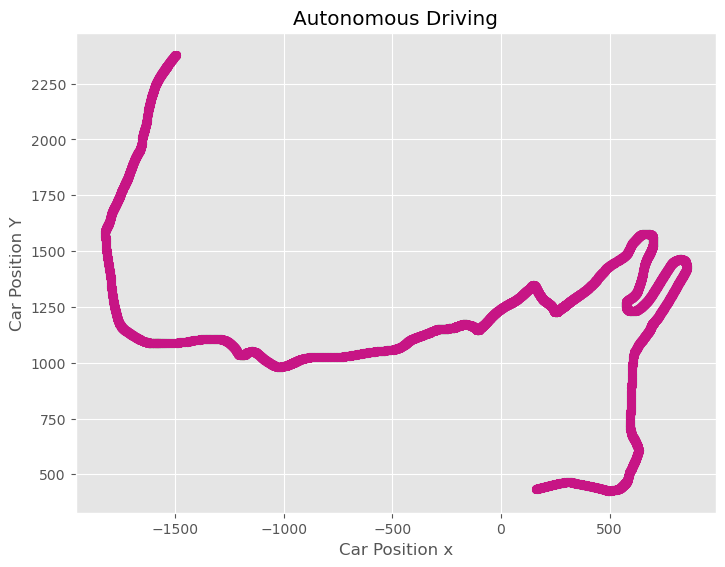

In [48]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(x=Auto["CarPosition_x"],y=Auto["CarPosition_z"], color='mediumvioletred')
#ax.scatter(x=Man["CarPosition_x"],y=Man["CarPosition_z"], color='b')
ax.set_xlabel('Car Position x')
ax.set_ylabel('Car Position Y')
ax.set_title('Autonomous Driving')
plt.show()

In [49]:
event = Auto.loc[Auto['Event'] == 'two']

In [50]:
event

,Time_duration,timestamp_REF,uid,Condition,TobiiTimeStamp,UnixTimeStamp,Man_Timestamp,HmdPosition_x,HmdPosition_y,HmdPosition_z,...,CarRotation_z,CarRotation_w,TimeStampNr,Auto_TimeStamp,Auto_TobiiTimeStamp,SteeringInput,AcellerationInput,BrakeInput,Frame,Event
10762400,63.372070,1970-01-01 02:57:43.037109375+00:00,017397ca31114170abc2ff61a217460b,Autonomous,10663.037109,1.630156e+09,2021-08-28 12:59:38.662925568+00:00,639.483765,372.433319,1088.876953,...,-0.018042,0.929880,3223,2021-08-28 12:59:38.662925568+00:00,10663.037109,-0.378550,1.0,0.0,3224,two
10762401,63.394531,1970-01-01 02:57:43.059570312+00:00,017397ca31114170abc2ff61a217460b,Autonomous,10663.059570,1.630156e+09,2021-08-28 12:59:38.685862912+00:00,639.710205,372.378876,1089.146362,...,-0.018137,0.928956,3224,2021-08-28 12:59:38.685862912+00:00,10663.059570,-0.392908,1.0,0.0,3225,two
10762402,63.416992,1970-01-01 02:57:43.082031250+00:00,017397ca31114170abc2ff61a217460b,Autonomous,10663.082031,1.630156e+09,2021-08-28 12:59:38.707804416+00:00,639.936157,372.324585,1089.413818,...,-0.018173,0.928560,3225,2021-08-28 12:59:38.707804416+00:00,10663.082031,-0.406807,1.0,0.0,3226,two
10762403,63.437500,1970-01-01 02:57:43.102539062+00:00,017397ca31114170abc2ff61a217460b,Autonomous,10663.102539,1.630156e+09,2021-08-28 12:59:38.728748288+00:00,640.162292,372.270538,1089.679565,...,-0.018225,0.928201,3226,2021-08-28 12:59:38.728748288+00:00,10663.102539,-0.420707,1.0,0.0,3227,two
10762404,63.449219,1970-01-01 02:57:43.114257812+00:00,017397ca31114170abc2ff61a217460b,Autonomous,10663.102539,1.630156e+09,2021-08-28 12:59:38.728748288+00:00,640.162292,372.270538,1089.679565,...,-0.018225,0.928201,3227,2021-08-28 12:59:38.739719168+00:00,10663.114258,-0.420707,1.0,0.0,3228,two
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10763404,81.786133,1970-01-01 02:58:01.451171875+00:00,017397ca31114170abc2ff61a217460b,Autonomous,10681.440430,1.630156e+09,2021-08-28 12:59:57.066438400+00:00,736.350952,346.498505,1225.794434,...,-0.016767,0.949721,4227,2021-08-28 12:59:57.077410048+00:00,10681.451172,-0.636655,1.0,0.0,4228,two
10763405,81.808594,1970-01-01 02:58:01.473632812+00:00,017397ca31114170abc2ff61a217460b,Autonomous,10681.473633,1.630156e+09,2021-08-28 12:59:57.098353152+00:00,736.795227,346.391510,1226.432373,...,-0.016526,0.949413,4228,2021-08-28 12:59:57.098353152+00:00,10681.473633,-0.645942,1.0,0.0,4229,two
10763406,81.819336,1970-01-01 02:58:01.484375+00:00,017397ca31114170abc2ff61a217460b,Autonomous,10681.484375,1.630156e+09,2021-08-28 12:59:57.111319040+00:00,736.795166,346.391418,1226.432495,...,-0.016365,0.949130,4229,2021-08-28 12:59:57.111319040+00:00,10681.484375,-0.650555,1.0,0.0,4230,two
10763407,81.841797,1970-01-01 02:58:01.506835937+00:00,017397ca31114170abc2ff61a217460b,Autonomous,10681.506836,1.630156e+09,2021-08-28 12:59:57.132807424+00:00,737.016968,346.338867,1226.749268,...,-0.016259,0.948871,4230,2021-08-28 12:59:57.132807424+00:00,10681.506836,-0.659383,1.0,0.0,4231,two


In [51]:
Shadi= event

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set up the color palette with seaborn
palette = sns.color_palette("hsv", len(Shadi['Frame'].unique()))

# Create a directory to store the images
if not os.path.exists('plots'):
    os.makedirs('plots')

# Loop over each unique time point
for i, time in enumerate(Shadi['Frame'].unique()):
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # First plot all the data with a base color, for example gray
    ax.scatter(Shadi['CarPosition_x'], Shadi['CarPosition_z'], color='gray', label='All data')
    
    # Then filter the dataframe for the current time point
    df_temp = Shadi[Shadi['Frame'] == time]
    
    # Create a scatter plot for the current time point with a unique color
    ax.scatter(df_temp['CarPosition_x'], df_temp['CarPosition_z'], color=palette[i], label=f'Frame: {time}')
    
    ax.set_xlabel('CarPosition_x')
    ax.set_ylabel('CarPosition_z')
    ax.legend()

    # Save the plot in the 'plots' directory
    plt.savefig(f'plots/plot_{time}.png', dpi=300)
    plt.close()

In [ ]:
import os
import cv2

images_folder = r'/Users/shadiderakhshan/Library/CloudStorage/Dropbox/PaythonScripts/EEDA/EEDA_EH_Analysis/PLOTS'
video_name = "Path_event10.mp4"
fps = 10.0


def make_video(image_folder, video_name, fps):
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    images.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))

    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    # Use the 'mp4v' codec
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps,
                            (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()


make_video(images_folder, video_name, fps)

In [ ]:
event

In [52]:
label_mapping = {'Manual': '1', 'Autonomous': '0'}
df5['conditions'] = df5['Condition'].map(label_mapping)

In [53]:
def biplot_1(score,
             coef,
             labels=None,
             colors=None,
             explained_variance=None,
             vector_colors=None,
             vector_linewidth=5):
    xs = score[:, 0]
    ys = score[:, 1]
    n = coef.shape[0]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())

    if colors is None:  # If no color information, plot all points orange
        plt.scatter(xs * scalex, ys * scaley, s=5, color='orange')
    else:  # If color information is given, plot points with corresponding colors
        plt.scatter(xs * scalex, ys * scaley, s=5, color=colors)

    labels = labels[:
                    n]  # Adjust the number of labels to match the number of coefficients
    for i in range(n):
        plt.arrow(0, 0, coef[i, 0], coef[i, 1], color=vector_colors[i], alpha=0.5, linewidth=vector_linewidth)
        if labels is not None:
            plt.text(coef[i, 0] * 1.15, coef[i, 1] * 1.15, 
                     f"{labels[i]} ({coef[i, 0]:.2f}, {coef[i, 1]:.2f})", 
                     color='black', ha='center', va='center')

    plt.xlabel("PC{} ({:.1f}%)".format(1, explained_variance[0] * 100))
    plt.ylabel("PC{} ({:.1f}%)".format(2, explained_variance[1] * 100))

    # Add a legend for the colors if provided
    if colors is not None:
        legend_elements = [
            Line2D([0], [0],
                   marker='o',
                   color='w',
                   markerfacecolor='black',
                   markersize=5,
                   label='Manual'),
            Line2D([0], [0],
                   marker='o',
                   color='w',
                   markerfacecolor='red',
                   markersize=5,
                   label='Autonomous')
        ]
        plt.legend(handles=legend_elements)

In [ ]:
#......................### 1. Define the columns of the df that we want to use in PCA ###......................#
feature_names = [
    #'H_pos_x', 'H_pos_y', 'H_pos_z', #Head position
    'H_dir_x',
    'H_dir_y',
    'H_dir_z',  #Head direction
    #'E_pos_x', 'E_pos_y', 'E_pos_z', #Eye position
    'E_dir_x',
    'E_dir_y',
    'E_dir_z',  #Eye direction
    #'C_pos_x', 'C_pos_y', 'C_pos_z', #Car position
    #'Car_rot_x', 'Car_rot_y', 'Car_rot_z', 'Car_rot_w', #Car rotation
    'Steering',
    'conditions'  # steering orientation angel
]

#......................### 2. Extracting rows based on specific timestamps ###......................#
timestamps = df5[(df5['Frame'] >= 3224)
                 & (df5['Frame'] <= 4232)]['Frame'].unique()

# - Create a directory to save plots
if not os.path.exists('plots'):
    os.makedirs('plots')

#......................### 3. Loop over unique timestamps ###......................#
for timestamp in timestamps:
    # 3.1. Extract rows for this timestamp
    subset = df5[np.isclose(df5['Frame'], timestamp)]
    # 3.2. Ensure only the columns in feature_names are used
    subset_features = subset[subset.columns.intersection(feature_names)]

    # - Generate an array of colors based on 'Condition'
    colors = [
        'black' if condition == 'Manual' else 'red'
        for condition in subset['Condition']
    ]

    #......................### 4. Scale the subset of the data ###......................#
    # 4.1. Standardizes the features by subtracting the mean and dividing by the standard deviation
    scaler = StandardScaler()
    subset_scaled = scaler.fit_transform(subset_features)

    #......................### 5. Perform PCA on the subset of the data ###......................#
    # 5.1. Compute the covariance matrix
    # 5.2. Compute the eigenvectors and eigenvalues
    # 5.3. Select the principal components
    # 5.4. Construct the feature transformation matrix
    # 5.5. Project the data

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(subset_scaled)
    explained_variance = pca.explained_variance_ratio_
    
    # Calculate eigenvalues from the explained variance of each principal component
    #total_variance = np.sum(np.var(subset_scaled, axis=0))
    #eigenvalues = pca.explained_variance_ * total_variance

    #......................### 6. Create a biplot of the first two principal components ###......................#
    plt.figure(figsize=(12, 10))
    plt.title('Frame ' + str(timestamp))
    biplot_1(pca_result,
           np.transpose(pca.components_),
           list(subset_features.columns),
           colors,
           explained_variance,
           vector_colors=[
               '#cab2d6', '#cab2d6', '#cab2d6', '#6a3d9a', '#6a3d9a', '#6a3d9a', 'green', 'orange'
           ], vector_linewidth=5)
    
    # Add the eigenvalues to the plot
    #plt.text(0, 0, "Eigenvalues: {:.2f}, {:.2f}".format(*eigenvalues), fontsize=12)

    # - Save the plot to a file
    plt.savefig('plots/biplot_' + str(timestamp) + '.png', dpi=300)

In [ ]:
import cv2

images_folder = r'/Users/shadiderakhshan/Library/CloudStorage/Dropbox/PaythonScripts/EEDA/EEDA_EH_Analysis/PLOTS'
video_name = "PCA_event_10.mp4"
fps = 10.0


def make_video(image_folder, video_name, fps):
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    images.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))

    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    # Use the 'mp4v' codec
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps,
                            (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()


make_video(images_folder, video_name, fps)

In [ ]:
from moviepy.editor import VideoFileClip, clips_array

# 1. Read the videos
video1 = VideoFileClip("Path_event10.mp4")
video2 = VideoFileClip("PCA_event_10.mp4")

# 2. Resize videos (if needed)
video1_resized = video1#.resize(height=480)
video2_resized = video2#.resize(height=480)

# 3. Concatenate
final_clip = clips_array([[video1_resized, video2_resized]])

# 4. Write the result to a file
final_clip.write_videofile("event_ten.mp4")